# E4 - hyperparameter optimisation
## 1. Generating sequences and scores list
Recall that OneHotEncoder wants each sequence as a list of amino acids, and all the sequences formatted as a list of lists. The data file provided does not provide the sequences of each mutant, or directly provide the wild-type sequence. It does, however provide the starting amino acid at each position, and what it is mutated to. We can therefore iterate through the csv and find the wild sequence from the starting amino acid at each position. This is done by wild_seq. We can then Go through each mutation, copying the wild sequence and just changing the amino acid to match the mutation while recording the score of that mutation. This is done by mut_seqs. seqs_scores just combines wild_seq and mut_seqs to keep the code tidy. 

In [45]:
import pandas as pd
# Find the wild type sequence from the csv file
def wild_seq(csv_file: str) -> list:
    wild_seq = []
    csv = pd.read_csv(csv_file, usecols=["start", "position"])
    position = 0
    for index, row in csv.iterrows():
        if row["position"] != position:
            wild_seq.append(row["start"])
            position = row["position"]
    return wild_seq

def mut_seqs(csv_file: str, wild_seq: list):
    mut_seqs = []
    current_seq = []
    csv = pd.read_csv(csv_file, usecols=["position","end","score"])
    scores = []
    for index, row in csv.iterrows():
        if not pd.isna(row["score"]) and row["end"] != "X":
            current_seq = wild_seq.copy()
            current_seq[row["position"]-1] = row["end"]
            mut_seqs.append(current_seq)
            scores.append(row["score"])
    return mut_seqs, scores

def seqs_scores(csv_file):
    wildseq = wild_seq(csv_file)
    seqs, scores = mut_seqs(csv_file, wildseq)
    return seqs, scores

seqs, scores = seqs_scores("PTEN.csv")

## 2. OneHotEncoding
The next step is to one-hot encode with OneHotEncoder. And split into training and testing sets.

In [46]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

enc = OneHotEncoder(handle_unknown='ignore')
onehot_seqs = enc.fit_transform(seqs, scores)

X_train, X_test, y_train, y_test = train_test_split(onehot_seqs, scores, test_size=0.2, random_state=42)

## 3. Dimensionality reduction


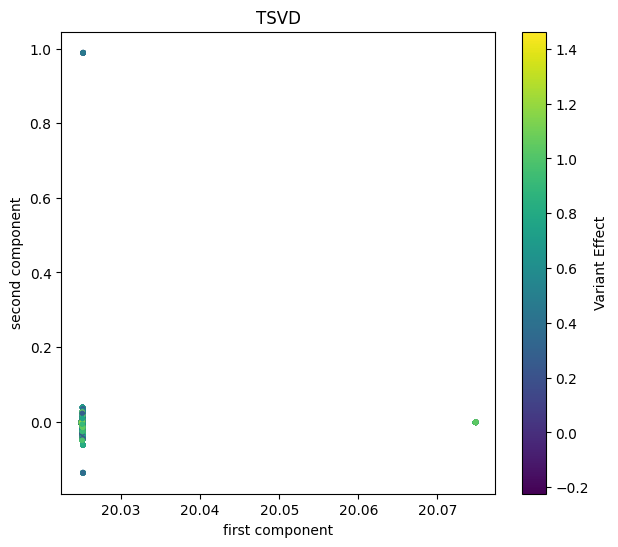

In [47]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

tsvd = TruncatedSVD(n_components=30)
X_train_tsvd = tsvd.fit_transform(X_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_tsvd[:,0], X_train_tsvd[:,1], c=y_train, marker='.')
ax.set_xlabel('first component')
ax.set_ylabel('second component')
ax.set_title('TSVD')
plt.colorbar(sc, label='Variant Effect')

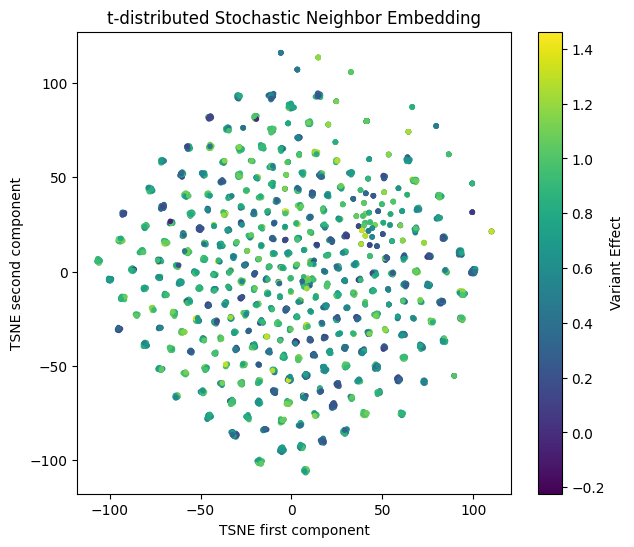

In [48]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000)
X_train_tsne = tsne.fit_transform(X_train_tsvd)


fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_tsne[:,0], X_train_tsne[:,1], c=y_train, marker='.')
ax.set_xlabel('TSNE first component')
ax.set_ylabel('TSNE second component')
ax.set_title('t-distributed Stochastic Neighbor Embedding')
plt.colorbar(sc, label='Variant Effect')

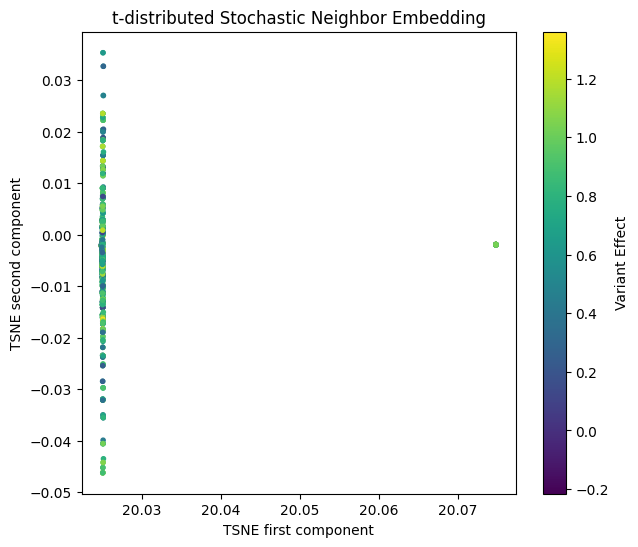

In [49]:
X_test_tsvd = tsvd.transform(X_test)

fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_test_tsvd[:,0], X_test_tsvd[:,1], c=y_test, marker='.')
ax.set_xlabel('TSNE first component')
ax.set_ylabel('TSNE second component')
ax.set_title('t-distributed Stochastic Neighbor Embedding')
plt.colorbar(sc, label='Variant Effect')

## 3. Fitting without hyperparameter optimisation


In [50]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_tsvd, y_train)
r_squared = knn.score(X_test_tsvd, y_test)
mean_sqr_err = mean_squared_error(y_test, knn.predict(X_test_tsvd))

print(f'R^2: {r_squared} \nMean squared error: {mean_sqr_err}')

R^2: 0.36761147537960004 
Mean squared error: 0.058533454923794734


## 4. Hyperparameter optimisation with GridSearchCV


In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # adjust values as needed
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']  # adjust metrics as needed
}
knn_grid = KNeighborsRegressor()

grid_search = GridSearchCV(knn_grid, param_grid, scoring='r2')
grid_search.fit(X_train_tsvd, y_train)
best_grid_params = grid_search.best_params_
best_grid_score = grid_search.best_score_

print("Best parameters:", best_grid_params)

best_grid_knn = grid_search.best_estimator_
grid_score = best_grid_knn.score(X_test_tsvd, y_test)
grid_mean_sqr_err = mean_squared_error(y_test, best_grid_knn.predict(X_test_tsvd))

print(f'R^2: {grid_score} \nMean squared error: {grid_mean_sqr_err}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
R^2: 0.3899632546629639 
Mean squared error: 0.05646458932264435


## 5. Hyperparameter optimisation with RandomSearchCV

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution for KNN
param_dist = {
    'n_neighbors': randint(1, 20),  # adjust the range as needed
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']  # adjust metrics as needed
}

knn_random = KNeighborsRegressor()

random_search = RandomizedSearchCV(knn_grid, param_dist, scoring='r2')
random_search.fit(X_train_tsvd, y_train)
best_random_params = random_search.best_params_
best_random_score = random_search.best_score_

print("Best parameters:", best_random_params)

best_random_knn = random_search.best_estimator_
random_score = best_random_knn.score(X_test_tsvd, y_test)
random_mean_sqr_err = mean_squared_error(y_test, best_random_knn.predict(X_test_tsvd))

print(f'R^2: {random_score} \nMean squared error: {random_mean_sqr_err}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}
R^2: 0.38744864212415075 
Mean squared error: 0.05669734016166342


## 6. Trying different regressors

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Setting up search distributions
knn_dist = {
    'n_neighbors': randint(1, 20),  # adjust the range as needed
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']  # adjust metrics as needed
}
rf_dist = {
    'n_estimators': randint(50, 500),  # adjust the range as needed
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(5, 50),  # adjust the range as needed
    'min_samples_split': randint(2, 20),  # adjust the range as needed
    'min_samples_leaf': randint(5, 15),  # adjust the range as needed
    'bootstrap': [True]
}

svr_dist = {
    'C': range(1,5),  # adjust the range as needed
    'gamma': ['scale', 'auto'],  # or specify a distribution for gamma
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}


# Running a RandomSearchCV for each architecture
reg_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_dist_list = [knn_dist, svr_dist, rf_dist]


dist_list = []
for reg, dist in zip(reg_list, param_dist_list):
    print(reg)
    search = RandomizedSearchCV(
        estimator = reg(),
        param_distributions = dist,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1, # use all available cores
        n_iter=40
    )
    search.fit(X_train_tsvd, y_train)
    dist_list.append(search)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 40 candidates, totalling 200 fits
<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/home/anthosbz/Documents/Learning_ML/First_ML/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/anthosbz/Documents/Learning_ML/First_ML/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
110 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anthosbz/Documents/Learning_ML/First_ML/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anthosbz/Documents/Learning_ML/First_ML/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/anthosbz/Documents/Learning_ML/First_ML/.venv/lib/python

In [61]:
print(f"knn best score: {dist_list[0].best_score_} \nsvr best score: {dist_list[1].best_score_} \nrf best score: {dist_list[2].best_score_}")
print(f"knn best params: {dist_list[0].best_params_} \nsvr best params: {dist_list[1].best_params_} \nrf best params: {dist_list[2].best_params_}")

knn best score: 0.4495843290370119 
svr best score: 0.11290388388319261 
rf best score: 0.467386109826781
knn best params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'} 
svr best params: {'kernel': 'poly', 'gamma': 'auto', 'C': 4} 
rf best params: {'bootstrap': True, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 338}
